In [ ]:
# Google Colabでライブラリをアップロードする
from google.colab import files
uploaded = files.upload()

In [ ]:
# Google Colabでドライブのデータを使う
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Google Colabでライブラリをインストールする
!pip install japanize_matplotlib bottleneck tslearn

In [4]:
# 自作関数
import MasterResearchFunction as mr

# 基本ライブラリ
import csv
import math
import os
import pickle
import random
import re
import statistics
from datetime import datetime, timedelta
from decimal import Decimal

# 数値計算とデータ処理
import bottleneck as bn
import numpy as np
import pandas as pd

# 機械学習ライブラリ
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

# ディープラーニングライブラリ
import tensorflow as tf
from tensorflow.keras.layers import (
    Activation,
    Add,
    Conv1D,
    Dense,
    Dropout,
    Flatten,
    GlobalAveragePooling1D,
    Input,
    LayerNormalization,
    LSTM,
    Masking,
    MaxPooling1D,
    MultiHeadAttention,
)
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical


# プロットと可視化
import japanize_matplotlib
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

# その他のライブラリ
from fastdtw import fastdtw
from scipy import signal, stats
from scipy.interpolate import interp1d, UnivariateSpline
from scipy.signal import savgol_filter
from scipy.spatial.distance import euclidean
from tslearn.metrics import dtw_path

In [1858]:
motion_data = mr.process_apple_watch_csv('/Users/hinase/CodeChord/MasterResearch/datasets/new/uchida/motion/with_Tobii/uchida_eye_check.csv')
eye_data = mr.process_tobii_csv('/Users/hinase/CodeChord/MasterResearch/datasets/new/uchida/eye/raw/train/uchida_circle_cross_tri_check.csv')

In [ ]:
eye = mr.process_tobii_csv('/Users/hinase/CodeChord/MasterResearch/datasets/new/takagawa/eye/takagawa_eye_new_routine.csv')

In [ ]:
# 列36を確認
data_preview = pd.read_csv('/Users/hinase/CodeChord/MasterResearch/datasets/new/takagawa/eye/takagawa_eye_new_routine.csv', header=0, usecols=[36])
print(data_preview.head())

In [1859]:
# 25秒減算坂本
#eye_data["Timestamp"] = eye_data["Timestamp"] - pd.to_timedelta(25.659, unit='s')
#eye_data["Timestamp"] = eye_data["Timestamp"] - pd.to_timedelta(25.4841, unit='s')
#eye_data["Timestamp"] = eye_data["Timestamp"] - pd.to_timedelta(22.831, unit='s')
# 29秒減算渡部
#eye_data["Timestamp"] = eye_data["Timestamp"] - pd.to_timedelta(29.644, unit='s')
# 43秒減算小寺
#eye_data["Timestamp"] = eye_data["Timestamp"] - pd.to_timedelta(43.0029, unit='s')
# 43秒減算小寺(tri, check)
#eye_data["Timestamp"] = eye_data["Timestamp"] - pd.to_timedelta(42.045, unit='s')
#eye_data["Timestamp"] = eye_data["Timestamp"] - pd.to_timedelta(42.958, unit='s')
# 43秒減算中沢（circle, tri）
#eye_data["Timestamp"] = eye_data["Timestamp"] - pd.to_timedelta(38.43, unit='s')
# 43秒減算中沢（cross）
#eye_data["Timestamp"] = eye_data["Timestamp"] + pd.to_timedelta(11.486, unit='s')
#eye_data["Timestamp"] = eye_data["Timestamp"] - pd.to_timedelta(43.66, unit='s')
# 43秒減算水野（cross）
#eye_data["Timestamp"] = eye_data["Timestamp"] - pd.to_timedelta(2.043, unit='s')
# 43秒減算水野（tri）
#eye_data["Timestamp"] = eye_data["Timestamp"] - pd.to_timedelta(2.171, unit='s')
# 43秒減算水野（circle, check）
#eye_data["Timestamp"] = eye_data["Timestamp"] - pd.to_timedelta(1.994, unit='s')
#eye_data["Timestamp"] = eye_data["Timestamp"] - pd.to_timedelta(0.1, unit='s')
# 中沢
#eye_data["Timestamp"] = eye_data["Timestamp"] - pd.to_timedelta(1.1, unit='s')
#小寺
#eye_data["Timestamp"] = eye_data["Timestamp"] - pd.to_timedelta(3.6, unit='s')
#eye_data["Timestamp"] = eye_data["Timestamp"] - pd.to_timedelta(3.64, unit='s')
#eye_data["Timestamp"] = eye_data["Timestamp"] - pd.to_timedelta(3.62, unit='s')
#eye_data["Timestamp"] = eye_data["Timestamp"] + pd.to_timedelta(3.633, unit='s')
eye_data["Timestamp"] = eye_data["Timestamp"] - pd.to_timedelta(3.833, unit='s')

In [ ]:
eye_data["Timestamp"]

In [ ]:
motion_data["Timestamp"]

In [ ]:
Timestamp('2024-12-16 16:05:03.058607101')

In [1863]:
#hinase_circle_seg = mr.three_axis_spring(motion_data, train_data, [5, 5, 5], 'acc')

In [1864]:
Hz = 100

In [1870]:
a = mr.find_true_intervals(motion_data)

In [ ]:
a

In [ ]:
len(a)

In [ ]:
motion_data["Timestamp"][8619]

In [1873]:
#b = []

In [ ]:
i

In [ ]:
a[i]

In [2047]:
i = i + 1

In [ ]:
i

In [2042]:
b.append([a[i][0]+60, a[i][1]-130])

In [ ]:
b

In [ ]:
len(b)

In [ ]:
for j in range(len(b)):
  print(b[j][1] - b[j][0])

In [2038]:
del b[20]

In [ ]:
for j in range(len(b)):
  print(b[j][1] - b[j][0])

In [ ]:
for i in range(len(a)):
  print(a[i][1] - a[i][0])

In [ ]:
len(b)

In [753]:
del b[15]

In [2050]:
c = []
for i in range(len(b)):
  c.append([motion_data["Timestamp"][b[i][0]], motion_data["Timestamp"][b[i][1]]])

In [ ]:
c

In [ ]:
# 各範囲内のデータを格納するリストを用意します
result = []
# cの各行に対してループを回します
for start_time, end_time in c:
    # 範囲内のデータを抽出するためのマスクを作成します
    mask = (eye_data["Timestamp"] >= start_time) & (eye_data["Timestamp"] <= end_time)
    # マスクを適用してデータを抽出します
    data_in_range = eye_data.loc[mask]
    # 結果をリストに追加します
    result.append(data_in_range)

# 結果を確認します
for idx, data in enumerate(result):
    print(f"範囲 {idx+1}:")
    print(data)
    print("\n")

In [ ]:
len(result)

In [2053]:
# pickleファイルに出力する
with open('/Users/hinase/CodeChord/MasterResearch/datasets/new/uchida/eye/train_pickle/uchida_check_eye.pkl', 'wb') as f:
    pickle.dump(result, f)

In [2]:
# 定数の定義
NAMES = ['sakamoto', 'watabe', 'kotera', 'nakazawa', 'mizuno', 'todaka', 'takagawa', 'uchida']
LABELS = ['circle', 'cross', 'tri', 'check']
COLUMNS_TO_DROP = [
    'Sensor', 'Participant name', 'Event', 'Event value',
    'Eye movement type', 'Eye movement type index', 'Ungrouped',
    'Validity left', 'Validity right', 'Gaze event duration', 'Gaze2D_Distance',
    'Fixation_Distance', 'Gaze3D_Distance', 'Pupil_Diameter_Change',
    'GazeDirection_Distance', 'PupilPosition_Distance'
]
# インターバルのパラメータ設定
MIN_INTERVAL = 0.84  # 最小インターバル長（秒）
MAX_INTERVAL = 3.04  # 最大インターバル長（秒）
NUM_INTERVALS = 180  # 抽出するインターバルの数

In [14]:
# データとラベルを格納するリストの初期化
X_filled = []
y_labels = []
true_labels = []
# データとラベルを格納する辞書の初期化
data_dict = {}
label_dict = {}
true_label_dict = {}

for name in NAMES:
    print(f"Processing {name}...")

    # データの読み込みと前処理
    eye_data, gesture_labels = mr.load_gesture_eye_data_pickle(name, LABELS, COLUMNS_TO_DROP)
    data_dict[name] = {'gesture': eye_data, 'non_gesture': []}
    label_dict[name] = {'gesture': gesture_labels, 'non_gesture': []}
    true_label_dict[name] = {'gesture': ['gesture'] * len(eye_data), 'non_gesture': []}

    # モーションデータとアイデータの読み込み
    motion_routine_data, eye_routine_data = mr.load_motion_and_eye_data(name)
    eye_non_gesture_data = mr.process_tobii_csv(f'datasets/new/{name}/eye/{name}_non_gesture.csv')

    # gestureデータの長さを算出
    if isinstance(eye_data, list):
        lengths = [df.shape[0] for df in eye_data]  # 各データフレームの行数を取得
        longest_length = max(lengths)
        shortest_length = min(lengths)
    else:
        longest_length = eye_data.shape[0]
        shortest_length = eye_data.shape[0]

    print(f"{name} の gesture データの長さ: 最長 {longest_length}, 最短 {shortest_length}")

    # ランダムな長さでデータを抽出
    NON_GESTURE = 180
    random_non_gesture_data = []

    # ランダムな長さでデータを抽出（重複を防ぐために利用可能なインデックスを管理）
    available_indices = list(range(eye_non_gesture_data.shape[0]))
    random_non_gesture_data = []

    for _ in range(NON_GESTURE):
        # ランダムな長さを決定
        random_length = random.randint(shortest_length, longest_length)

        # 利用可能なインデックスからランダムに開始位置を選択
        possible_start_indices = [
            idx for idx in available_indices if idx + random_length <= len(available_indices)
        ]
        if not possible_start_indices:
            print(f"{name} の non-gesture データに十分なインデックスがありません。")
            break

        start_idx = random.choice(possible_start_indices)
        end_idx = start_idx + random_length

        # 抽出したデータを追加
        random_non_gesture_data.append(eye_non_gesture_data.iloc[start_idx:end_idx])

        # 使用済みインデックスを削除
        available_indices = [idx for idx in available_indices if idx < start_idx or idx >= end_idx]

    # 抽出したデータを辞書に格納
    data_dict[name]['non_gesture'] = random_non_gesture_data
    label_dict[name]['non_gesture'] = ['non_gesture'] * len(random_non_gesture_data)
    true_label_dict[name]['non_gesture'] = ['non_gesture'] * len(random_non_gesture_data)

    print(f"{name} の non-gesture データから {len(random_non_gesture_data)} 個のランダムデータを抽出しました。")

    # ジェスチャーデータの統合
    for seq, lbl, true_lbl in zip(eye_data, gesture_labels, true_label_dict[name]['gesture']):
        if seq is not None and len(seq) > 0:
            X_filled.append(seq)
            y_labels.append(lbl)
            true_labels.append(true_lbl)
        else:
            print(f"{name} のジェスチャーシーケンスが空です。対応するラベルをスキップします。")

    # 非ジェスチャーデータの統合
    for seq, lbl, true_lbl in zip(data_dict[name]['non_gesture'], label_dict[name]['non_gesture'], true_label_dict[name]['non_gesture']):
        if isinstance(seq, pd.DataFrame):
            if not seq.empty:
                X_filled.append(seq)
                y_labels.append(lbl)
                true_labels.append(true_lbl)
            else:
                print(f"{name} の非ジェスチャーシーケンスが空です。対応するラベルをスキップします。")
        else:
            print(f"{name} の非ジェスチャーシーケンスが DataFrame ではありません。スキップします。")


Processing sakamoto...
sakamoto の gesture データの長さ: 最長 134, 最短 71
sakamoto の non-gesture データから 180 個のランダムデータを抽出しました。
Processing watabe...
watabe の gesture データの長さ: 最長 128, 最短 69
watabe の non-gesture データから 180 個のランダムデータを抽出しました。
Processing kotera...
kotera の gesture データの長さ: 最長 93, 最短 42
kotera の non-gesture データから 180 個のランダムデータを抽出しました。
Processing nakazawa...
nakazawa の gesture データの長さ: 最長 107, 最短 54
nakazawa の non-gesture データから 180 個のランダムデータを抽出しました。
Processing mizuno...
mizuno の gesture データの長さ: 最長 152, 最短 70
mizuno の non-gesture データから 180 個のランダムデータを抽出しました。
Processing todaka...
todaka の gesture データの長さ: 最長 97, 最短 49
todaka の non-gesture データから 180 個のランダムデータを抽出しました。
Processing takagawa...


/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:132: DtypeWarning: Columns (36) have mixed types. Specify dtype option on import or set low_memory=False.
  eye_data = pd.read_csv(file_path, header=0)


takagawa の gesture データの長さ: 最長 133, 最短 85
takagawa の non-gesture データから 180 個のランダムデータを抽出しました。
Processing uchida...
uchida の gesture データの長さ: 最長 135, 最短 71
uchida の non-gesture データから 180 個のランダムデータを抽出しました。


In [15]:
print(f"総データ数: {len(X_filled)}")
print(f"総ラベル数（y_labels）: {len(y_labels)}")
print(f"総真偽ラベル数（true_labels）: {len(true_labels)}")

総データ数: 2109
総ラベル数（y_labels）: 2109
総真偽ラベル数（true_labels）: 2109


In [11]:
len(true_label_dict['sakamoto']['gesture'])

80

In [5]:
# データとラベルを格納するリストの初期化
X_filled = []
y_labels = []
true_labels = []
# データとラベルを格納する辞書の初期化
data_dict = {}
label_dict = {}
true_label_dict = {}

for name in NAMES:
    print(f"Processing {name}...")

    # データの読み込みと前処理
    eye_data, gesture_labels = mr.load_gesture_eye_data_pickle(name, LABELS, COLUMNS_TO_DROP)
    # 変数に保存
    data_dict[name] = {
        'gesture': eye_data,
        'non_gesture': []
    }
    label_dict[name] = {
        'gesture': gesture_labels,
        'non_gesture': []
    }
    true_label_dict[name] = {
        'gesture': ['gesture'] * len(eye_data),
        'non_gesture': []
    }

    # モーションデータとアイデータの読み込みと前処理
    motion_routine_data, eye_routine_data = mr.load_motion_and_eye_data(name)
    eye_non_gesture_data = mr.process_tobii_csv(f'datasets/new/{name}/eye/{name}_non_gesture.csv')
    # # 変数に保存
    # motion_data = motion_routine_data

    # # 除外インターバルの取得
    # exclusion_intervals = mr.get_exclusion_intervals(motion_data)

    # # データ全体の時間範囲の取得
    # start_time = motion_routine_data['Timestamp'].min()
    # end_time = motion_routine_data['Timestamp'].max()

    # # 利用可能なインターバルの取得
    # available_intervals = mr.get_available_intervals(exclusion_intervals, start_time, end_time)

    # print(f"{name} の利用可能なインターバル数: {len(available_intervals)}")

    # # ランダムなインターバルの抽出（eye_routine_data を使用）
    # extracted_data = mr.extract_random_intervals(
    #     eye_routine_data, available_intervals, MIN_INTERVAL, MAX_INTERVAL, NUM_INTERVALS
    # )

    # # 抽出されたデータを辞書に保存
    # data_dict[name]['non_gesture'] = extracted_data
    # label_dict[name]['non_gesture'] = ['non_gesture'] * len(extracted_data)
    # true_label_dict[name]['non_gesture'] = ['non_gesture'] * len(extracted_data)

    # # ジェスチャーデータの統合
    # for seq, lbl, true_lbl in zip(eye_data, gesture_labels, true_label_dict[name]['gesture']):
    #     if seq is not None and len(seq) > 0:
    #         X_filled.append(seq)
    #         y_labels.append(lbl)
    #         true_labels.append(true_lbl)
    #     else:
    #         print(f"{name} のジェスチャーシーケンスが空です。対応するラベルをスキップします。")

    # # 非ジェスチャーデータの統合
    # for seq, lbl, true_lbl in zip(data_dict[name]['non_gesture'], label_dict[name]['non_gesture'], true_label_dict[name]['non_gesture']):
    #     if isinstance(seq, pd.DataFrame):
    #         if not seq.empty:
    #             X_filled.append(seq)
    #             y_labels.append(lbl)
    #             true_labels.append(true_lbl)
    #         else:
    #             print(f"{name} の非ジェスチャーシーケンスが空です。対応するラベルをスキップします。")
    #     else:
    #         print(f"{name} の非ジェスチャーシーケンスが DataFrame ではありません。スキップします。")

print(f"総データ数: {len(X_filled)}")
print(f"総ラベル数（y_labels）: {len(y_labels)}")
print(f"総真偽ラベル数（true_labels）: {len(true_labels)}")

Processing sakamoto...
Processing watabe...
Processing kotera...
Processing nakazawa...
Processing mizuno...
Processing todaka...
Processing takagawa...


/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:132: DtypeWarning: Columns (36) have mixed types. Specify dtype option on import or set low_memory=False.
  eye_data = pd.read_csv(file_path, header=0)


Processing uchida...
総データ数: 0
総ラベル数（y_labels）: 0
総真偽ラベル数（true_labels）: 0


In [16]:
# タイムスタンプのギャップを確認
for name in NAMES:
    non_gesture_intervals = data_dict[name]['non_gesture']
    if non_gesture_intervals:
        for idx, eye_routine_data in enumerate(non_gesture_intervals):
            if isinstance(eye_routine_data, pd.DataFrame):
                if not eye_routine_data.empty:
                    time_diffs = eye_routine_data['Timestamp'].diff().dt.total_seconds()
                    large_gaps = time_diffs[time_diffs > 0.05]
                    print(f"{name} の non_gesture_intervals[{idx}] の大きなタイムスタンプギャップ数: {len(large_gaps)}")
                else:
                    print(f"{name} の non_gesture_intervals[{idx}] が空です。")
            else:
                print(f"{name} の non_gesture_intervals[{idx}] が DataFrame ではありません。")

sakamoto の non_gesture_intervals[0] の大きなタイムスタンプギャップ数: 0
sakamoto の non_gesture_intervals[1] の大きなタイムスタンプギャップ数: 0
sakamoto の non_gesture_intervals[2] の大きなタイムスタンプギャップ数: 0
sakamoto の non_gesture_intervals[3] の大きなタイムスタンプギャップ数: 0
sakamoto の non_gesture_intervals[4] の大きなタイムスタンプギャップ数: 0
sakamoto の non_gesture_intervals[5] の大きなタイムスタンプギャップ数: 0
sakamoto の non_gesture_intervals[6] の大きなタイムスタンプギャップ数: 0
sakamoto の non_gesture_intervals[7] の大きなタイムスタンプギャップ数: 0
sakamoto の non_gesture_intervals[8] の大きなタイムスタンプギャップ数: 0
sakamoto の non_gesture_intervals[9] の大きなタイムスタンプギャップ数: 0
sakamoto の non_gesture_intervals[10] の大きなタイムスタンプギャップ数: 0
sakamoto の non_gesture_intervals[11] の大きなタイムスタンプギャップ数: 0
sakamoto の non_gesture_intervals[12] の大きなタイムスタンプギャップ数: 0
sakamoto の non_gesture_intervals[13] の大きなタイムスタンプギャップ数: 0
sakamoto の non_gesture_intervals[14] の大きなタイムスタンプギャップ数: 0
sakamoto の non_gesture_intervals[15] の大きなタイムスタンプギャップ数: 0
sakamoto の non_gesture_intervals[16] の大きなタイムスタンプギャップ数: 0
sakamoto の non_gesture_intervals[17] の大きな

In [17]:
# 2. 前処理とフィルタリングの適用
filtered_X, filtered_y, filtered_true = mr.preprocess_and_filter_sequences(
    X_filled,
    y_labels,
    true_labels,
    sampling_rate=50.0,
    max_gap_seconds=0.1,
    max_nan_seconds=1.0
)

/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:821: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[gaze_col] = df[gaze_col].fillna(method='ffill').fillna(method='bfill')
/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:840: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[gaze_col] = df[gaze_col].fillna(method='ffill').fillna(method='bfill')
/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:860: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[spline_col] = df[spline_col].fillna(method='ffill').fillna(method='bfill')
/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:872: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future versi

シーケンス 100 は1秒以上連続するNaNを含むため、削除されました。


/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:872: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[col] = df[col].fillna(method='ffill').fillna(method='bfill')
/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:821: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[gaze_col] = df[gaze_col].fillna(method='ffill').fillna(method='bfill')
/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:840: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[gaze_col] = df[gaze_col].fillna(method='ffill').fillna(method='bfill')
/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:860: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ff

シーケンス 204 は1秒以上連続するNaNを含むため、削除されました。
シーケンス 223 は1秒以上連続するNaNを含むため、削除されました。


/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:872: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[col] = df[col].fillna(method='ffill').fillna(method='bfill')
/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:821: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[gaze_col] = df[gaze_col].fillna(method='ffill').fillna(method='bfill')
/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:840: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[gaze_col] = df[gaze_col].fillna(method='ffill').fillna(method='bfill')
/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:860: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ff

シーケンス 244 は1秒以上連続するNaNを含むため、削除されました。
シーケンス 248 は1秒以上連続するNaNを含むため、削除されました。


/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:840: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[gaze_col] = df[gaze_col].fillna(method='ffill').fillna(method='bfill')
/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:860: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[spline_col] = df[spline_col].fillna(method='ffill').fillna(method='bfill')
/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:872: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[col] = df[col].fillna(method='ffill').fillna(method='bfill')
/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:821: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use ob

シーケンス 396 は1秒以上連続するNaNを含むため、削除されました。
シーケンス 409 は1秒以上連続するNaNを含むため、削除されました。
シーケンス 417 は1秒以上連続するNaNを含むため、削除されました。


/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:860: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[spline_col] = df[spline_col].fillna(method='ffill').fillna(method='bfill')
/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:872: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[col] = df[col].fillna(method='ffill').fillna(method='bfill')
/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:821: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[gaze_col] = df[gaze_col].fillna(method='ffill').fillna(method='bfill')
/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:840: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use ob

シーケンス 442 は1秒以上連続するNaNを含むため、削除されました。
シーケンス 455 は1秒以上連続するNaNを含むため、削除されました。
シーケンス 468 は1秒以上連続するNaNを含むため、削除されました。


/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:872: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[col] = df[col].fillna(method='ffill').fillna(method='bfill')
/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:821: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[gaze_col] = df[gaze_col].fillna(method='ffill').fillna(method='bfill')
/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:840: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[gaze_col] = df[gaze_col].fillna(method='ffill').fillna(method='bfill')
/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:860: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ff

シーケンス 497 は1秒以上連続するNaNを含むため、削除されました。
シーケンス 510 は1秒以上連続するNaNを含むため、削除されました。


/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:872: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[col] = df[col].fillna(method='ffill').fillna(method='bfill')
/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:821: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[gaze_col] = df[gaze_col].fillna(method='ffill').fillna(method='bfill')
/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:840: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[gaze_col] = df[gaze_col].fillna(method='ffill').fillna(method='bfill')
/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:860: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ff

シーケンス 627 は1秒以上連続するNaNを含むため、削除されました。
シーケンス 633 は1秒以上連続するNaNを含むため、削除されました。
シーケンス 643 は1秒以上連続するNaNを含むため、削除されました。
シーケンス 654 は1秒以上連続するNaNを含むため、削除されました。


/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:840: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[gaze_col] = df[gaze_col].fillna(method='ffill').fillna(method='bfill')
/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:860: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[spline_col] = df[spline_col].fillna(method='ffill').fillna(method='bfill')
/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:872: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[col] = df[col].fillna(method='ffill').fillna(method='bfill')
/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:821: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use ob

シーケンス 699 は1秒以上連続するNaNを含むため、削除されました。
シーケンス 702 は1秒以上連続するNaNを含むため、削除されました。
シーケンス 708 は1秒以上連続するNaNを含むため、削除されました。
シーケンス 725 は1秒以上連続するNaNを含むため、削除されました。


/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:840: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[gaze_col] = df[gaze_col].fillna(method='ffill').fillna(method='bfill')
/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:860: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[spline_col] = df[spline_col].fillna(method='ffill').fillna(method='bfill')
/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:872: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[col] = df[col].fillna(method='ffill').fillna(method='bfill')
/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:821: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use ob

シーケンス 771 は1秒以上連続するNaNを含むため、削除されました。


/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:860: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[spline_col] = df[spline_col].fillna(method='ffill').fillna(method='bfill')
/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:872: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[col] = df[col].fillna(method='ffill').fillna(method='bfill')
/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:821: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[gaze_col] = df[gaze_col].fillna(method='ffill').fillna(method='bfill')
/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:840: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use ob

シーケンス 886 は1秒以上連続するNaNを含むため、削除されました。


/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:860: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[spline_col] = df[spline_col].fillna(method='ffill').fillna(method='bfill')
/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:872: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[col] = df[col].fillna(method='ffill').fillna(method='bfill')
/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:821: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[gaze_col] = df[gaze_col].fillna(method='ffill').fillna(method='bfill')
/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:840: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use ob

シーケンス 928 は1秒以上連続するNaNを含むため、削除されました。
残る NaN を 0 で埋めます。
シーケンス 949 は1秒以上連続するNaNを含むため、削除されました。


/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:821: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[gaze_col] = df[gaze_col].fillna(method='ffill').fillna(method='bfill')
/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:840: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[gaze_col] = df[gaze_col].fillna(method='ffill').fillna(method='bfill')
/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:860: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[spline_col] = df[spline_col].fillna(method='ffill').fillna(method='bfill')
/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:872: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future versi

シーケンス 963 は1秒以上連続するNaNを含むため、削除されました。
シーケンス 984 は1秒以上連続するNaNを含むため、削除されました。
シーケンス 985 は1秒以上連続するNaNを含むため、削除されました。
シーケンス 988 は1秒以上連続するNaNを含むため、削除されました。


/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:860: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[spline_col] = df[spline_col].fillna(method='ffill').fillna(method='bfill')
/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:872: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[col] = df[col].fillna(method='ffill').fillna(method='bfill')
/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:821: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[gaze_col] = df[gaze_col].fillna(method='ffill').fillna(method='bfill')
/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:840: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use ob

シーケンス 998 は1秒以上連続するNaNを含むため、削除されました。
シーケンス 1000 は1秒以上連続するNaNを含むため、削除されました。


/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:860: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[spline_col] = df[spline_col].fillna(method='ffill').fillna(method='bfill')
/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:872: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[col] = df[col].fillna(method='ffill').fillna(method='bfill')
/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:821: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[gaze_col] = df[gaze_col].fillna(method='ffill').fillna(method='bfill')
/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:840: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use ob

シーケンス 1029 は1秒以上連続するNaNを含むため、削除されました。
シーケンス 1033 は1秒以上連続するNaNを含むため、削除されました。


/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:872: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[col] = df[col].fillna(method='ffill').fillna(method='bfill')
/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:821: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[gaze_col] = df[gaze_col].fillna(method='ffill').fillna(method='bfill')
/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:840: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[gaze_col] = df[gaze_col].fillna(method='ffill').fillna(method='bfill')
/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:860: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ff

シーケンス 1165 は1秒以上連続するNaNを含むため、削除されました。
シーケンス 1174 は1秒以上連続するNaNを含むため、削除されました。
シーケンス 1188 は1秒以上連続するNaNを含むため、削除されました。


/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:860: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[spline_col] = df[spline_col].fillna(method='ffill').fillna(method='bfill')
/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:872: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[col] = df[col].fillna(method='ffill').fillna(method='bfill')
/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:821: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[gaze_col] = df[gaze_col].fillna(method='ffill').fillna(method='bfill')
/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:840: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use ob

シーケンス 1200 は1秒以上連続するNaNを含むため、削除されました。
シーケンス 1214 は1秒以上連続するNaNを含むため、削除されました。


/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:860: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[spline_col] = df[spline_col].fillna(method='ffill').fillna(method='bfill')
/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:872: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[col] = df[col].fillna(method='ffill').fillna(method='bfill')
/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:821: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[gaze_col] = df[gaze_col].fillna(method='ffill').fillna(method='bfill')
/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:840: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use ob

シーケンス 1241 は1秒以上連続するNaNを含むため、削除されました。
シーケンス 1246 は1秒以上連続するNaNを含むため、削除されました。
シーケンス 1253 は1秒以上連続するNaNを含むため、削除されました。


/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:860: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[spline_col] = df[spline_col].fillna(method='ffill').fillna(method='bfill')
/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:872: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[col] = df[col].fillna(method='ffill').fillna(method='bfill')
/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:821: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[gaze_col] = df[gaze_col].fillna(method='ffill').fillna(method='bfill')
/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:840: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use ob

シーケンス 1281 は1秒以上連続するNaNを含むため、削除されました。
シーケンス 1298 は1秒以上連続するNaNを含むため、削除されました。


/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:840: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[gaze_col] = df[gaze_col].fillna(method='ffill').fillna(method='bfill')
/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:860: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[spline_col] = df[spline_col].fillna(method='ffill').fillna(method='bfill')
/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:872: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[col] = df[col].fillna(method='ffill').fillna(method='bfill')
/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:821: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use ob

シーケンス 1310 は1秒以上連続するNaNを含むため、削除されました。
シーケンス 1316 は1秒以上連続するNaNを含むため、削除されました。
シーケンス 1319 は1秒以上連続するNaNを含むため、削除されました。


/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:840: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[gaze_col] = df[gaze_col].fillna(method='ffill').fillna(method='bfill')
/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:860: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[spline_col] = df[spline_col].fillna(method='ffill').fillna(method='bfill')
/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:872: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[col] = df[col].fillna(method='ffill').fillna(method='bfill')
/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:821: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use ob

シーケンス 1406 は1秒以上連続するNaNを含むため、削除されました。
シーケンス 1415 は1秒以上連続するNaNを含むため、削除されました。
シーケンス 1417 は1秒以上連続するNaNを含むため、削除されました。
残る NaN を 0 で埋めます。


/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:840: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[gaze_col] = df[gaze_col].fillna(method='ffill').fillna(method='bfill')
/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:860: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[spline_col] = df[spline_col].fillna(method='ffill').fillna(method='bfill')
/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:872: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[col] = df[col].fillna(method='ffill').fillna(method='bfill')
/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:821: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use ob

シーケンス 1452 は1秒以上連続するNaNを含むため、削除されました。
残る NaN を 0 で埋めます。
シーケンス 1473 は1秒以上連続するNaNを含むため、削除されました。


/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:860: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[spline_col] = df[spline_col].fillna(method='ffill').fillna(method='bfill')
/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:872: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[col] = df[col].fillna(method='ffill').fillna(method='bfill')
/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:821: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[gaze_col] = df[gaze_col].fillna(method='ffill').fillna(method='bfill')
/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:840: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use ob

シーケンス 1500 は1秒以上連続するNaNを含むため、削除されました。
シーケンス 1517 は1秒以上連続するNaNを含むため、削除されました。


/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:840: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[gaze_col] = df[gaze_col].fillna(method='ffill').fillna(method='bfill')
/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:860: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[spline_col] = df[spline_col].fillna(method='ffill').fillna(method='bfill')
/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:872: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[col] = df[col].fillna(method='ffill').fillna(method='bfill')
/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:821: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use ob

シーケンス 1530 は1秒以上連続するNaNを含むため、削除されました。


/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:840: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[gaze_col] = df[gaze_col].fillna(method='ffill').fillna(method='bfill')
/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:860: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[spline_col] = df[spline_col].fillna(method='ffill').fillna(method='bfill')
/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:872: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[col] = df[col].fillna(method='ffill').fillna(method='bfill')
/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:821: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use ob

残る NaN を 0 で埋めます。


/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:840: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[gaze_col] = df[gaze_col].fillna(method='ffill').fillna(method='bfill')
/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:860: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[spline_col] = df[spline_col].fillna(method='ffill').fillna(method='bfill')
/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:872: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[col] = df[col].fillna(method='ffill').fillna(method='bfill')
/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:821: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use ob

シーケンス 1674 は1秒以上連続するNaNを含むため、削除されました。
シーケンス 1686 は1秒以上連続するNaNを含むため、削除されました。


/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:872: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[col] = df[col].fillna(method='ffill').fillna(method='bfill')
/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:821: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[gaze_col] = df[gaze_col].fillna(method='ffill').fillna(method='bfill')
/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:840: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[gaze_col] = df[gaze_col].fillna(method='ffill').fillna(method='bfill')
/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:860: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ff

シーケンス 1717 は1秒以上連続するNaNを含むため、削除されました。


/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:860: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[spline_col] = df[spline_col].fillna(method='ffill').fillna(method='bfill')
/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:872: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[col] = df[col].fillna(method='ffill').fillna(method='bfill')
/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:821: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[gaze_col] = df[gaze_col].fillna(method='ffill').fillna(method='bfill')
/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:840: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use ob

シーケンス 1760 は1秒以上連続するNaNを含むため、削除されました。
シーケンス 1763 は1秒以上連続するNaNを含むため、削除されました。
シーケンス 1786 は1秒以上連続するNaNを含むため、削除されました。


/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:872: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[col] = df[col].fillna(method='ffill').fillna(method='bfill')
/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:821: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[gaze_col] = df[gaze_col].fillna(method='ffill').fillna(method='bfill')
/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:840: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[gaze_col] = df[gaze_col].fillna(method='ffill').fillna(method='bfill')
/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:860: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ff

シーケンス 1789 は1秒以上連続するNaNを含むため、削除されました。
シーケンス 1805 は1秒以上連続するNaNを含むため、削除されました。


/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:872: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[col] = df[col].fillna(method='ffill').fillna(method='bfill')
/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:821: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[gaze_col] = df[gaze_col].fillna(method='ffill').fillna(method='bfill')
/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:840: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[gaze_col] = df[gaze_col].fillna(method='ffill').fillna(method='bfill')
/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:860: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ff

シーケンス 1813 は1秒以上連続するNaNを含むため、削除されました。
シーケンス 1838 は1秒以上連続するNaNを含むため、削除されました。


/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:872: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[col] = df[col].fillna(method='ffill').fillna(method='bfill')
/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:821: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[gaze_col] = df[gaze_col].fillna(method='ffill').fillna(method='bfill')
/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:840: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[gaze_col] = df[gaze_col].fillna(method='ffill').fillna(method='bfill')
/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:860: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ff

シーケンス 1841 は1秒以上連続するNaNを含むため、削除されました。
シーケンス 1844 は1秒以上連続するNaNを含むため、削除されました。
シーケンス 1845 は1秒以上連続するNaNを含むため、削除されました。


/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:860: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[spline_col] = df[spline_col].fillna(method='ffill').fillna(method='bfill')
/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:872: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[col] = df[col].fillna(method='ffill').fillna(method='bfill')
/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:821: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[gaze_col] = df[gaze_col].fillna(method='ffill').fillna(method='bfill')
/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:840: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use ob

シーケンス 1931 は1秒以上連続するNaNを含むため、削除されました。
シーケンス 1935 は1秒以上連続するNaNを含むため、削除されました。
シーケンス 1941 は1秒以上連続するNaNを含むため、削除されました。
シーケンス 1947 は1秒以上連続するNaNを含むため、削除されました。
シーケンス 1948 は1秒以上連続するNaNを含むため、削除されました。
シーケンス 1955 は1秒以上連続するNaNを含むため、削除されました。


/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:840: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[gaze_col] = df[gaze_col].fillna(method='ffill').fillna(method='bfill')
/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:860: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[spline_col] = df[spline_col].fillna(method='ffill').fillna(method='bfill')
/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:872: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[col] = df[col].fillna(method='ffill').fillna(method='bfill')
/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:821: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use ob

シーケンス 1977 は1秒以上連続するNaNを含むため、削除されました。
シーケンス 1980 は1秒以上連続するNaNを含むため、削除されました。
残る NaN を 0 で埋めます。
残る NaN を 0 で埋めます。
シーケンス 1985 は1秒以上連続するNaNを含むため、削除されました。
シーケンス 1988 は1秒以上連続するNaNを含むため、削除されました。
シーケンス 1990 は1秒以上連続するNaNを含むため、削除されました。
シーケンス 1992 は1秒以上連続するNaNを含むため、削除されました。
シーケンス 1994 は1秒以上連続するNaNを含むため、削除されました。
シーケンス 2001 は1秒以上連続するNaNを含むため、削除されました。
シーケンス 2003 は1秒以上連続するNaNを含むため、削除されました。
シーケンス 2010 は1秒以上連続するNaNを含むため、削除されました。
シーケンス 2011 は1秒以上連続するNaNを含むため、削除されました。


/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:840: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[gaze_col] = df[gaze_col].fillna(method='ffill').fillna(method='bfill')
/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:860: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[spline_col] = df[spline_col].fillna(method='ffill').fillna(method='bfill')
/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:872: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[col] = df[col].fillna(method='ffill').fillna(method='bfill')
/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:821: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use ob

シーケンス 2019 は1秒以上連続するNaNを含むため、削除されました。
シーケンス 2023 は1秒以上連続するNaNを含むため、削除されました。
シーケンス 2024 は1秒以上連続するNaNを含むため、削除されました。
シーケンス 2027 は1秒以上連続するNaNを含むため、削除されました。
シーケンス 2028 は1秒以上連続するNaNを含むため、削除されました。
シーケンス 2040 は1秒以上連続するNaNを含むため、削除されました。
シーケンス 2044 は1秒以上連続するNaNを含むため、削除されました。


/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:860: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[spline_col] = df[spline_col].fillna(method='ffill').fillna(method='bfill')
/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:872: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[col] = df[col].fillna(method='ffill').fillna(method='bfill')
/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:821: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[gaze_col] = df[gaze_col].fillna(method='ffill').fillna(method='bfill')
/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:840: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use ob

シーケンス 2053 は1秒以上連続するNaNを含むため、削除されました。
シーケンス 2054 は1秒以上連続するNaNを含むため、削除されました。
残る NaN を 0 で埋めます。
シーケンス 2056 は1秒以上連続するNaNを含むため、削除されました。
シーケンス 2058 は1秒以上連続するNaNを含むため、削除されました。
シーケンス 2060 は1秒以上連続するNaNを含むため、削除されました。
シーケンス 2063 は1秒以上連続するNaNを含むため、削除されました。
シーケンス 2064 は1秒以上連続するNaNを含むため、削除されました。
シーケンス 2070 は1秒以上連続するNaNを含むため、削除されました。
シーケンス 2073 は1秒以上連続するNaNを含むため、削除されました。
シーケンス 2078 は1秒以上連続するNaNを含むため、削除されました。
シーケンス 2079 は1秒以上連続するNaNを含むため、削除されました。
シーケンス 2080 は1秒以上連続するNaNを含むため、削除されました。
シーケンス 2081 は1秒以上連続するNaNを含むため、削除されました。
シーケンス 2082 は1秒以上連続するNaNを含むため、削除されました。


/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:840: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[gaze_col] = df[gaze_col].fillna(method='ffill').fillna(method='bfill')
/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:860: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[spline_col] = df[spline_col].fillna(method='ffill').fillna(method='bfill')
/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:872: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[col] = df[col].fillna(method='ffill').fillna(method='bfill')
/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:821: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use ob

シーケンス 2088 は1秒以上連続するNaNを含むため、削除されました。
シーケンス 2093 は1秒以上連続するNaNを含むため、削除されました。
シーケンス 2094 は1秒以上連続するNaNを含むため、削除されました。
シーケンス 2102 は1秒以上連続するNaNを含むため、削除されました。
シーケンス 2106 は1秒以上連続するNaNを含むため、削除されました。
シーケンス 2107 は1秒以上連続するNaNを含むため、削除されました。
フィルタリング後のデータ数: 1998


/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:840: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[gaze_col] = df[gaze_col].fillna(method='ffill').fillna(method='bfill')
/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:860: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[spline_col] = df[spline_col].fillna(method='ffill').fillna(method='bfill')
/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:872: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[col] = df[col].fillna(method='ffill').fillna(method='bfill')
/Users/hinase/CodeChord/MasterResearch/MasterResearchFunction.py:821: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use ob

In [18]:
# 最終的なデータの確認
print(f"処理後のデータ数: {len(filtered_X)}")
print(f"ラベル配列の長さ（y_labels_scaled）: {len(filtered_y)}")
print(f"真偽ラベル配列の長さ（true_labels_scaled）: {len(filtered_true)}")

処理後のデータ数: 1998
ラベル配列の長さ（y_labels_scaled）: 1998
真偽ラベル配列の長さ（true_labels_scaled）: 1998


In [19]:
X_scaled = []
scaler = StandardScaler()
for i in range(len(filtered_X)):
    X_scaled.append(scaler.fit_transform(filtered_X[i]))

In [20]:
# 4. ラベルのエンコーディング（2値分類用に修正）
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(filtered_true)  # 0または1にエンコード

# **ラベルのワンホットエンコーディングを削除**
# 2値分類では必要ありません
# y_categorical = to_categorical(y_encoded, num_classes=num_classes)

# 5. データの分割（パディングの前に行う）
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.3, random_state=42
)

In [21]:
for i, seq in enumerate(X_scaled):
    print(f"Sequence {i}: shape {seq.shape}")

Sequence 0: shape (95, 23)
Sequence 1: shape (101, 23)
Sequence 2: shape (98, 23)
Sequence 3: shape (106, 23)
Sequence 4: shape (93, 23)
Sequence 5: shape (99, 23)
Sequence 6: shape (110, 23)
Sequence 7: shape (99, 23)
Sequence 8: shape (116, 23)
Sequence 9: shape (111, 23)
Sequence 10: shape (105, 23)
Sequence 11: shape (107, 23)
Sequence 12: shape (104, 23)
Sequence 13: shape (93, 23)
Sequence 14: shape (111, 23)
Sequence 15: shape (110, 23)
Sequence 16: shape (102, 23)
Sequence 17: shape (102, 23)
Sequence 18: shape (96, 23)
Sequence 19: shape (109, 23)
Sequence 20: shape (113, 23)
Sequence 21: shape (93, 23)
Sequence 22: shape (117, 23)
Sequence 23: shape (116, 23)
Sequence 24: shape (107, 23)
Sequence 25: shape (109, 23)
Sequence 26: shape (116, 23)
Sequence 27: shape (109, 23)
Sequence 28: shape (116, 23)
Sequence 29: shape (117, 23)
Sequence 30: shape (121, 23)
Sequence 31: shape (132, 23)
Sequence 32: shape (110, 23)
Sequence 33: shape (111, 23)
Sequence 34: shape (119, 23)
Seq

In [22]:
# 6. 訓練データとテストデータでそれぞれ最大シーケンス長を計算
max_length_train = max(len(seq) for seq in X_train_raw)
max_length_test = max(len(seq) for seq in X_test_raw)
max_length = max(max_length_train, max_length_test)

# 7. シーケンスのパディング
X_train_padded = pad_sequences(X_train_raw, maxlen=max_length, padding='post', value=0.0, dtype='float32')
X_test_padded = pad_sequences(X_test_raw, maxlen=max_length, padding='post', value=0.0, dtype='float32')

# 8. パディング後のデータに NaN が含まれていないか確認
print('NaN in X_train_padded:', np.isnan(X_train_padded).any())
print('NaN in X_test_padded:', np.isnan(X_test_padded).any())

# 必要に応じて NaN を 0 で置換
if np.isnan(X_train_padded).any():
    X_train_padded = np.nan_to_num(X_train_padded, nan=0.0)
if np.isnan(X_test_padded).any():
    X_test_padded = np.nan_to_num(X_test_padded, nan=0.0)

NaN in X_train_padded: False
NaN in X_test_padded: False


In [23]:
def get_positional_encoding(max_len, d_model):
    """
    固定のサイン・コサイン位置エンコーディングを生成する関数。

    Parameters:
    - max_len (int): シーケンスの最大長
    - d_model (int): 埋め込み次元数

    Returns:
    - pos_encoding (np.array): 位置エンコーディング行列
    """
    angle_rads = np.arange(max_len)[:, np.newaxis] / np.power(10000, (2 * (np.arange(d_model)[np.newaxis, :]//2)) / np.float32(d_model))

    # 偶数次元はsin、奇数次元はcos
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]  # (1, max_len, d_model)
    return tf.cast(pos_encoding, dtype=tf.float32)

from tensorflow.keras.layers import Masking

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    """
    Transformerエンコーダーブロックを構築する関数。
    """
    # 自己注意機構（マスクは自動的に適用される）
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    x = Dropout(dropout)(x)
    x = LayerNormalization(epsilon=1e-6)(inputs + x)

    # フィードフォワードネットワーク
    x_ff = Dense(ff_dim, activation='relu')(x)
    x_ff = Dense(inputs.shape[-1])(x_ff)
    x_ff = Dropout(dropout)(x_ff)
    out = LayerNormalization(epsilon=1e-6)(x + x_ff)
    return out

def build_transformer_model(max_length, num_features, head_size, num_heads, ff_dim, num_transformer_blocks, dropout):
    """
    Transformerベースの2値分類モデルを構築する関数。
    """
    inputs = Input(shape=(max_length, num_features))

    # マスキングレイヤーの追加（パディング値が0の場合）
    x = Masking(mask_value=0.0)(inputs)

    # 位置エンコーディングの追加
    pos_encoding = get_positional_encoding(max_length, num_features)
    x = x + pos_encoding[:,:max_length, :]

    # Transformerエンコーダーブロックの追加
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    # グローバルプーリング
    x = GlobalAveragePooling1D()(x)
    x = Dropout(dropout)(x)

    # 出力層
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [24]:
from tensorflow.keras.optimizers import Adam

In [25]:
# モデルの構築
model = build_transformer_model(
    max_length=max_length,
    num_features=X_train_padded.shape[2],
    head_size=64,
    num_heads=8,
    ff_dim=128,
    num_transformer_blocks=1,
    dropout=0.1
)

# モデルのサマリー表示
model.summary()

# モデルのコンパイル
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# モデルの訓練
history = model.fit(
    X_train_padded, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test_padded, y_test),
)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 152, 23)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking (Masking)   │ (None, 152, 23)   │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 152, 23)   │          0 │ masking[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 152, 23)   │     48,663 │ add[0][0],        │
│ (MultiHeadAttentio… │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 152, 23)   │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 152, 23)   │          0 │ add[0][0],        │
│                     │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 152, 23)   │         46 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 152, 128)  │      3,072 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 152, 23)   │      2,967 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 152, 23)   │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 152, 23)   │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 152, 23)   │         46 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 23)        │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 23)        │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │         24 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 54,818 (214.13 KB)

 Trainable params: 54,818 (214.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.5849 - loss: 0.6935 - val_accuracy: 0.7100 - val_loss: 0.5972
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.7447 - loss: 0.5517 - val_accuracy: 0.7367 - val_loss: 0.5214
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - accuracy: 0.7511 - loss: 0.5027 - val_accuracy: 0.7550 - val_loss: 0.4727
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - accuracy: 0.8068 - loss: 0.4275 - val_accuracy: 0.7833 - val_loss: 0.4593
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.8248 - loss: 0.3879 - val_accuracy: 0.8167 - val_loss: 0.3950
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - accuracy: 0.8518 - loss: 0.3207 - val_accuracy: 0.8300 - val_loss: 0.3676
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - accuracy: 0.8863 - loss: 0.2856 - val_accuracy: 0.8767 - val_loss: 0.3284
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - accuracy: 0.9020 - loss: 0.2424 - val_accuracy: 0.

In [26]:
# 4. モデルの評価
loss, accuracy = model.evaluate(X_test_padded, y_test)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

# 5. 予測と結果の表示
y_pred_prob = model.predict(X_test_padded)
y_pred_classes = (y_pred_prob > 0.5).astype(int).flatten()  # 閾値0.5でクラスを決定
y_true_classes = y_test

# ラベルを逆変換（元のクラス名に戻す場合）
y_pred_labels = label_encoder.inverse_transform(y_pred_classes)
y_true_labels = label_encoder.inverse_transform(y_true_classes)

# 分類レポートの表示
print(classification_report(y_true_labels, y_pred_labels))

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9007 - loss: 0.8066
Test Loss: 0.9280834794044495
Test Accuracy: 0.8833333253860474
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
              precision    recall  f1-score   support

     gesture       0.82      0.84      0.83       204
 non_gesture       0.92      0.91      0.91       396

    accuracy                           0.88       600
   macro avg       0.87      0.87      0.87       600
weighted avg       0.88      0.88      0.88       600



In [28]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns

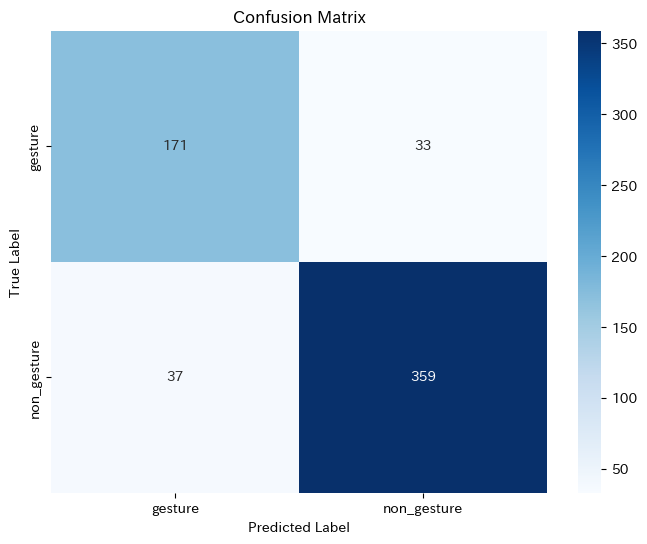

In [29]:
# 混同行列の作成と可視化
conf_mat = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# 1. 特徴量数を取得
num_features = X_train_padded.shape[2]
print(f"特徴量数: {num_features}")

# 2. モデルの構築（2値分類用に修正）
model = Sequential()
model.add(Masking(mask_value=0., input_shape=(max_length, num_features)))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))  # 出力層を1ユニットのシグモイドに変更

# 3. モデルのコンパイルと学習
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(
    X_train_padded, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test_padded, y_test)
)

# 4. モデルの評価
loss, accuracy = model.evaluate(X_test_padded, y_test)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

# 5. 予測と結果の表示
y_pred_prob = model.predict(X_test_padded)
y_pred_classes = (y_pred_prob > 0.5).astype(int).flatten()  # 閾値0.5でクラスを決定
y_true_classes = y_test

# ラベルを逆変換（元のクラス名に戻す場合）
y_pred_labels = label_encoder.inverse_transform(y_pred_classes)
y_true_labels = label_encoder.inverse_transform(y_true_classes)

# 分類レポートの表示
print(classification_report(y_true_labels, y_pred_labels))

In [ ]:
# 特徴量数を取得
num_features = X_train_padded.shape[2]
num_features

In [ ]:
# 4. モデルの構築
model = Sequential()
model.add(Masking(mask_value=0., input_shape=(max_length, num_features)))
model.add(LSTM(128))
model.add(Dense(num_classes, activation='sigmoid'))

# 5. モデルのコンパイルと学習
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(
    X_train_padded, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test_padded, y_test)
)

# 6. モデルの評価
loss, accuracy = model.evaluate(X_test_padded, y_test)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

# 7. 予測と結果の表示
y_pred = model.predict(X_test_padded)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)
y_pred_labels = label_encoder.inverse_transform(y_pred_classes)
y_true_labels = label_encoder.inverse_transform(y_true_classes)
print(classification_report(y_true_labels, y_pred_labels))

In [ ]:
input_shape = (max_length, num_features)
inputs = Input(shape=input_shape)
x = Masking(mask_value=0.)(inputs)

# num_featuresを定義（入力データの特徴量の次元数）
num_features = input_shape[1]

# Transformerブロックの定義
def transformer_block(x, num_heads, key_dim, ff_dim, rate=0.1):
    # マルチヘッド注意機構
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(x, x)
    attn_output = Dropout(rate)(attn_output)

    # 出力次元をnum_featuresに変換
    attn_output = Dense(num_features)(attn_output)

    out1 = Add()([x, attn_output])
    out1 = LayerNormalization(epsilon=1e-6)(out1)

    # フィードフォワードネットワーク
    ffn_output = Dense(ff_dim, activation='relu')(out1)

    # 出力次元をnum_featuresに変換
    ffn_output = Dense(num_features)(ffn_output)

    ffn_output = Dropout(rate)(ffn_output)
    out2 = Add()([out1, ffn_output])
    out2 = LayerNormalization(epsilon=1e-6)(out2)
    return out2

# Transformerブロックの適用
x = transformer_block(x, num_heads=4, key_dim=64, ff_dim=128)

# プーリングと出力層
x = GlobalAveragePooling1D()(x)
x = Dropout(0.1)(x)
outputs = Dense(num_classes, activation='sigmoid')(x)

# モデルの作成
model = Model(inputs=inputs, outputs=outputs)

In [ ]:
# 5. モデルのコンパイルと学習
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(
    X_train_padded, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test_padded, y_test)
)


In [ ]:
# 6. モデルの評価
loss, accuracy = model.evaluate(X_test_padded, y_test)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

# 7. 予測と結果の表示
y_pred = model.predict(X_test_padded)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)
y_pred_labels = label_encoder.inverse_transform(y_pred_classes)
y_true_labels = label_encoder.inverse_transform(y_true_classes)
print(classification_report(y_true_labels, y_pred_labels))

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# 8. 特徴量の重要度評価（Permutation Feature Importance）

# 8.1 ベースラインの性能を計算
# テストデータでの予測
y_pred = model.predict(X_test_padded)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# ベースラインのAccuracyを計算
baseline_accuracy = accuracy_score(y_true_classes, y_pred_classes)
print(f'Baseline Accuracy: {baseline_accuracy:.4f}')

# 8.2 特徴量ごとの重要度を計算
num_features = X_test_padded.shape[2]
feature_importances = []

for feature_idx in range(num_features):
    # テストデータをコピー
    X_test_permuted = X_test_padded.copy()

    # 特徴量をランダムにシャッフル（サンプル間でシャッフル）
    permuted_feature = X_test_permuted[:, :, feature_idx].reshape(X_test_permuted.shape[0], -1)
    np.random.shuffle(permuted_feature)
    X_test_permuted[:, :, feature_idx] = permuted_feature.reshape(X_test_permuted.shape[0], X_test_permuted.shape[1])

    # シャッフル後のデータで予測
    y_pred_permuted = model.predict(X_test_permuted)
    y_pred_classes_permuted = np.argmax(y_pred_permuted, axis=1)

    # シャッフル後のAccuracyを計算
    permuted_accuracy = accuracy_score(y_true_classes, y_pred_classes_permuted)

    # 性能の差を計算（重要度）
    importance = baseline_accuracy - permuted_accuracy
    feature_importances.append(importance)
    print(f'Feature {feature_idx + 1} Importance: {importance:.4f}')

# 8.3 特徴量重要度の可視化
feature_names = [f'Feature {i+1}' for i in range(num_features)]

plt.figure(figsize=(10, 6))
plt.barh(X[7].columns, feature_importances)
plt.xlabel('Decrease in Accuracy')
plt.title('Permutation Feature Importance')
plt.gca().invert_yaxis()
plt.show()


In [ ]:
#  pickleファイルを読み込む
with open('/Users/hinase/Downloads/Th-s/d_nakazawa_acc_check_segments4.7new.pkl', 'rb') as f:
    data = pickle.load(f)

segx = data['d_nakazawa_check_segx']
segy = data['d_nakazawa_check_segy']
segz = data['d_nakazawa_check_segz']

In [ ]:
# Create a simple sine wave as an example of a waveform or signal
x = np.linspace(0, 10, 1000)
y = np.sin(x)

# Define the sections to be colored
color_sections = [(200, 300, 'red'), (450, 550, 'blue'), (700, 800, 'red')]

# Plot the entire waveform in gray
plt.figure(figsize=(10, 2))
plt.plot(x, y, color='gray', linewidth=3)

# Highlight the specified sections with the chosen colors
for start, end, color in color_sections:
    plt.plot(x[start:end], y[start:end], color=color, linewidth=5)

# Add an arrow to indicate the flow of data
# plt.annotate('', xy=(10, 0), xytext=(0, 0),
#              arrowprops=dict(facecolor='black', shrink=0.05, width=2))
plt.xticks(color="None")
plt.yticks(color="None")
plt.tick_params(length=0)
# Remove axes for a cleaner look
plt.axis('off')
#plt.savefig("/Users/hinase/Downloads/plt.svg")

# Show plot
plt.show()

In [ ]:
import cairosvg

# SVGファイルのパス
input_svg_path = "/Users/hinase/Downloads/ss.svg"
# 出力するEPSファイルのパス
output_eps_path = "/Users/hinase/Downloads/ss.eps"

# SVGをEPSに変換
cairosvg.svg2eps(url=input_svg_path, write_to=output_eps_path)

print(f"SVG画像がEPS形式で '{output_eps_path}' に保存されました。")


In [6]:
import os
import csv
import openpyxl
from natsort import natsorted

folder_path = '/Users/hinase/Downloads/folder4'
folder_2_path = '/Users/hinase/Downloads/folder5'

# Get Excel file names in natural order, filtering only supported Excel files
supported_extensions = ('.xlsx', '.xlsm', '.xltx', '.xltm')
files = natsorted([f for f in os.listdir(folder_path) if f.endswith(supported_extensions)])

# Loop over filenames and build absolute path for each file
for filename in files:
    filepath = os.path.join(folder_path, filename)

    # Access xlsx file and get the first sheet object
    wb = openpyxl.load_workbook(filepath)
    ws_name = wb.sheetnames[0]
    ws = wb[ws_name]

    # Convert to csv and save to folder4
    savecsv_path = os.path.join(folder_2_path, filename.rstrip(".xlsx") + ".csv")
    with open(savecsv_path, 'w', newline="") as csvfile:
        writer = csv.writer(csvfile)
        for row in ws.rows:
            writer.writerow([cell.value for cell in row])


In [6]:
import numpy as np
import pylab as plt
import pandas as pd
import matplotlib.gridspec as gridspec
from tslearn.metrics import dtw_path

In [7]:
data = pd.read_csv("./data.csv", header=None)[1].values

In [ ]:
X = data[:1000:4]
Y = data[1000::4]

plt.figure(figsize=(6, 5))
plt.plot(X, label="Stream Data")
plt.plot(Y, label="Test Data")
plt.legend()
# PDFで保存
plt.savefig("/Users/hinase/Downloads/spring.pdf", format="pdf")  # PDF形式で保存
plt.show()  # グラフを表示

In [ ]:
from spring import spring
plt.figure(figsize=(6, 5))
# ループ内では凡例を設定せず、プロットのみ行う
for path, cost in spring(X, Y, 80):
    plt.plot(X, c="gray", alpha=0.5)  # 灰色の線
    plt.plot(path[:, 0], X[path[:, 0]], c="C2")  # 緑色の線

# ループの外で凡例を1回だけ設定
plt.plot([], [], c="C2", label="Segments identified as gesture performed")  # ダミーラインで凡例を作成
plt.legend(loc="upper right")  # 凡例を右上に固定
plt.savefig("/Users/hinase/Downloads/afterspring.pdf", format="pdf")  # PDF形式で保存
plt.show()  # グラフを表示